## SQAE with DRC 

Trying the Quantum autoencoder on larger MNIST images by encoding the high dimensional data using DRC

### imports 

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from hep_VQAE import data_preprocessing as dp
import tensorflow as tf
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
import time

import warnings
warnings.filterwarnings('ignore')

2022-08-11 08:56:01.109301: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-11 08:56:01.109322: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Circuit

In [2]:
DATA_QBITS = 9
LATENT_QBITS = 1
TRASH_QBITS = DATA_QBITS - LATENT_QBITS
TOTAL_QBITS = DATA_QBITS + TRASH_QBITS + 1

INPUT_DATA_SIZE = 15 # image width

DRCs = 1

In [3]:
dev1 = qml.device('lightning.qubit', wires=TOTAL_QBITS)

In [4]:
def single_upload(params, data, wire):
    for i, d in enumerate(data.flatten()):
        if i % 3 == 0:
            qml.RX(params[i * 2] + params[i * 2 + 1] * d, wires=wire)
        if i % 3 == 1:
            qml.RY(params[i * 2] + params[i * 2 + 1] * d, wires=wire)
        if i % 3 == 2:
            qml.RZ(params[i * 2] + params[i * 2 + 1] * d, wires=wire)

def conv_upload(params, img, kernel_size, stride, wires):
    number_of_kernel_uploads = len(list(range(0,img.shape[1]-kernel_size+1,stride)))*len(list(range(0,img.shape[0]-kernel_size+1,stride)))
    params_per_upload = len(params) // number_of_kernel_uploads
    upload_counter = 0
    wire = 0
    for y in range(0,img.shape[1]-kernel_size+1,stride):
        for x in range(0,img.shape[0]-kernel_size+1,stride):
            single_upload(params[upload_counter * params_per_upload: (upload_counter + 1) * params_per_upload],
                          img[y:y+kernel_size, x:x+kernel_size], wires[wire])
            upload_counter = upload_counter + 1
            wire = wire + 1
            
def circular_entanglement(wires):
    qml.CNOT(wires=[wires[-1], 0] )
    for i in range(len(wires)-1):
        qml.CNOT(wires=[i, i+1])

@qml.qnode(dev1)
def circuit(params, data):

    kernel_size = 5
    stride = 5
    
    number_of_kernel_uploads = len(list(range(0,data.shape[1]-kernel_size+1,stride)))**2
    num_upload_params = number_of_kernel_uploads*2*kernel_size**2
    
    for i in range(DRCs):
        conv_upload(params[i*num_upload_params:(i+1)*num_upload_params], data, kernel_size, stride, list(range(number_of_kernel_uploads)))
        circular_entanglement(list(range(number_of_kernel_uploads)))

    qml.Hadamard(wires=TOTAL_QBITS-1)
    for i in range(TRASH_QBITS):
        #c += cirq.ControlledGate(sub_gate=cirq.SWAP, num_controls=1).on(swap_qbit, reference_qbits[i], network_qbits[num_data_qbits - num_latent_qbits:][i])
        qml.CSWAP(wires=[TOTAL_QBITS - 1, LATENT_QBITS + i, DATA_QBITS + i])
    qml.Hadamard(wires=TOTAL_QBITS-1)
    return qml.expval(qml.PauliZ(TOTAL_QBITS-1))

In [5]:
data = np.random.rand(INPUT_DATA_SIZE,INPUT_DATA_SIZE)

kernel_size = 5
stride = 5
number_of_kernel_uploads = len(list(range(0,data.shape[0]-kernel_size+1,stride)))**2
num_upload_params = number_of_kernel_uploads*2*kernel_size**2

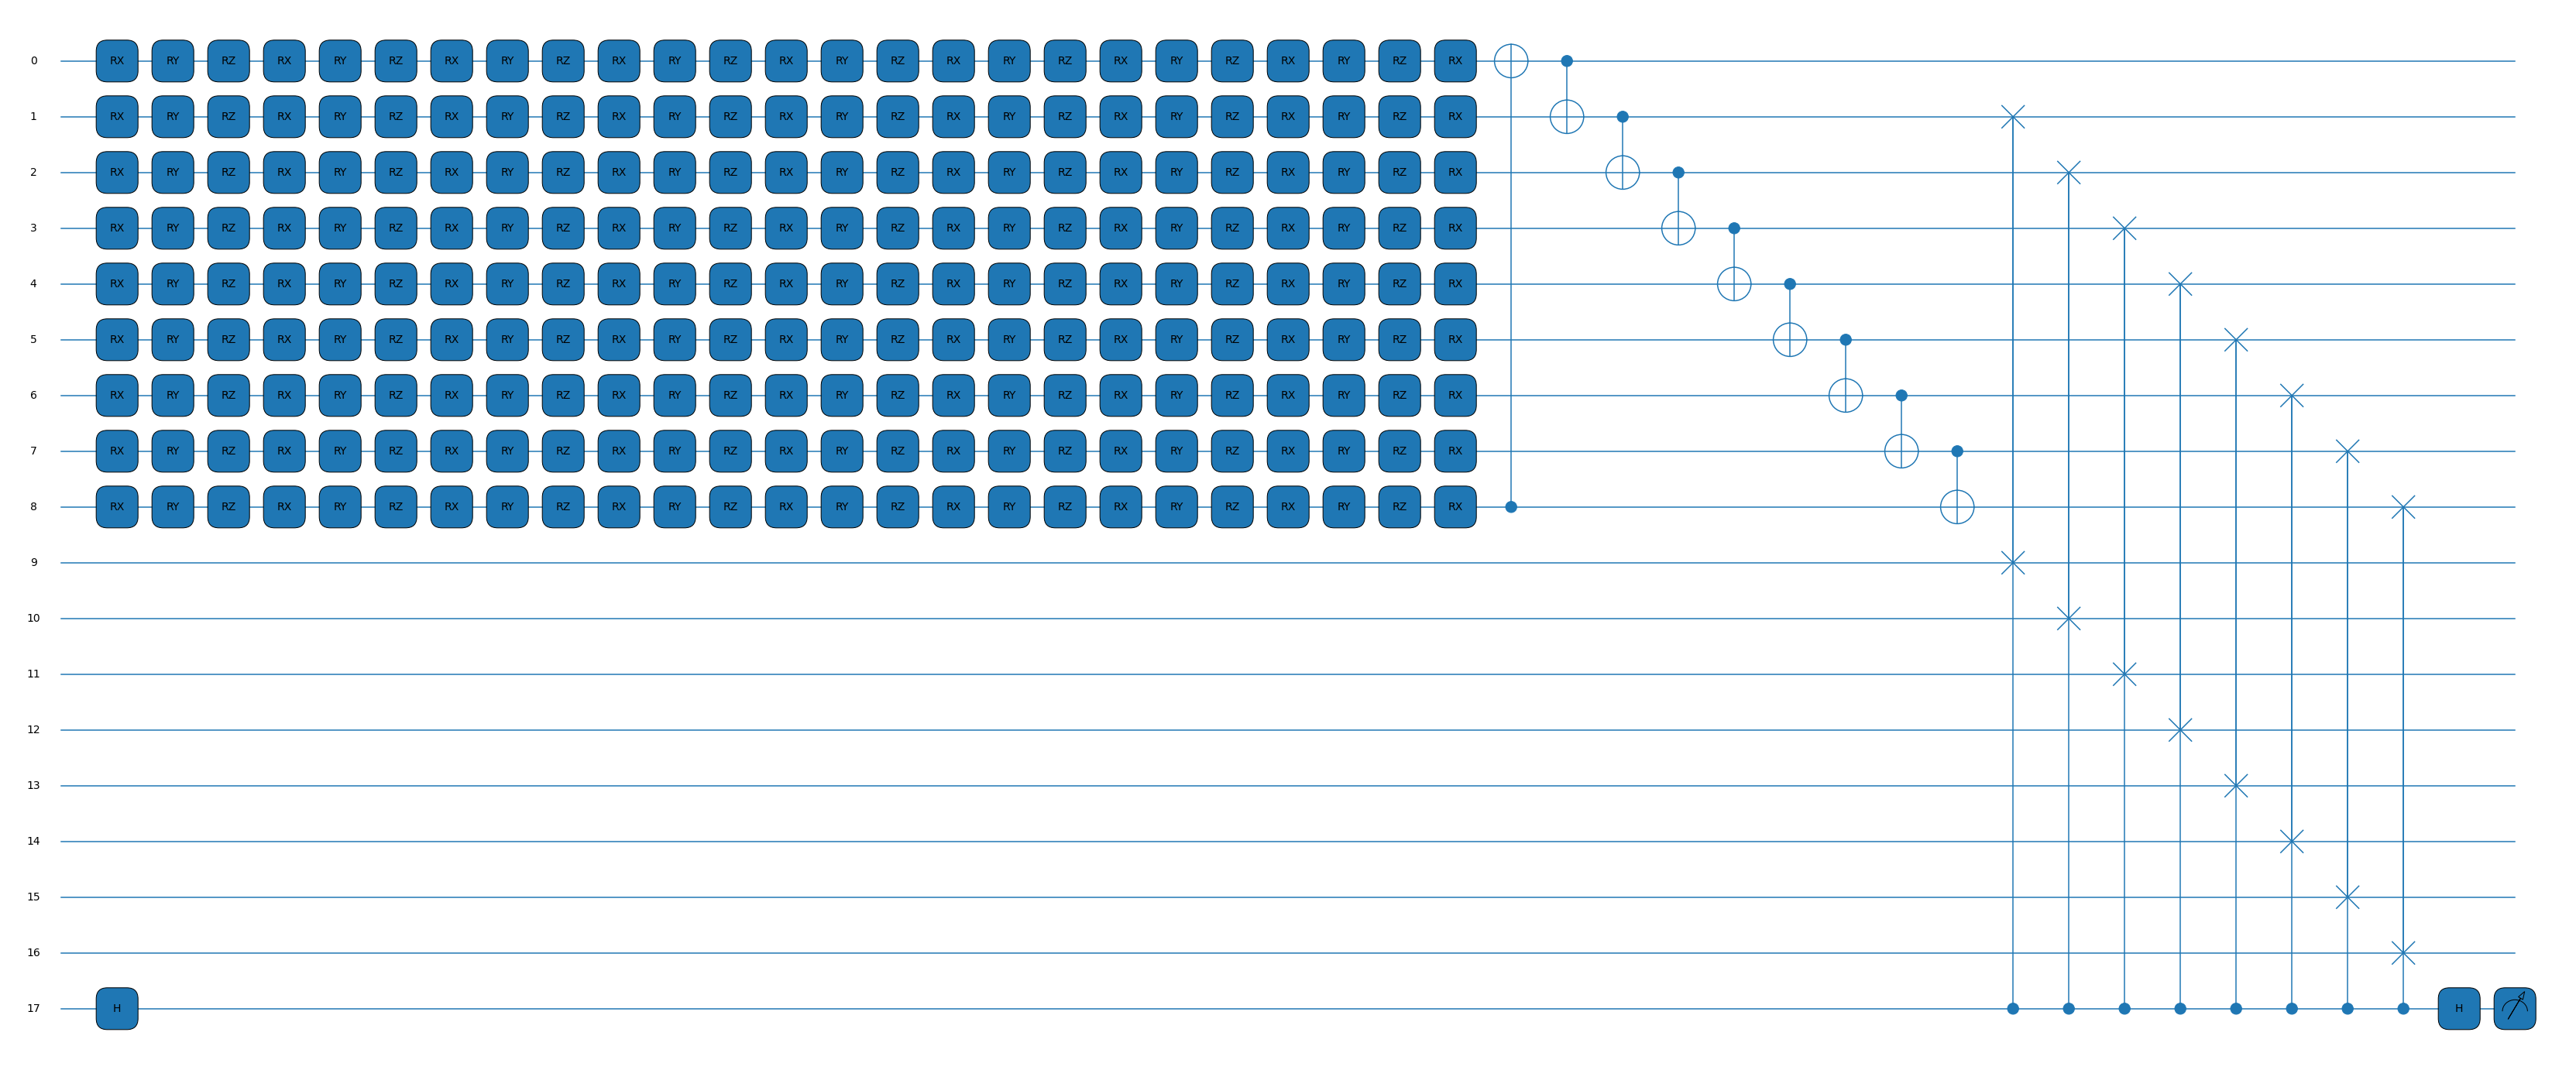

In [6]:
fig, ax = qml.draw_mpl(circuit)(np.ones(DRCs*num_upload_params),data)
fig.show()

## data 

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

In [8]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

x_train_threes = np.array(x_train[y_train==True])
x_train = np.array(x_train[y_train==False])

x_test_threes = np.array(x_test[y_test==True])
x_test = np.array(x_test[y_test==False])

In [9]:
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],x_train.shape[2],1))
x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],x_test.shape[2],1))

x_train_threes = x_train_threes.reshape((x_train_threes.shape[0],x_train_threes.shape[1],x_train_threes.shape[2],1))
x_test_threes = x_test_threes.reshape((x_test_threes.shape[0],x_test_threes.shape[1],x_test_threes.shape[2],1))

In [10]:
x_train_small = tf.image.resize(x_train, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()
x_test_small = tf.image.resize(x_test, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()

x_train_3_small = tf.image.resize(x_train_threes, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()
x_test_3_small = tf.image.resize(x_test_threes, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()

2022-08-11 08:56:04.470874: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-11 08:56:04.470902: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-11 08:56:04.470921: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2022-08-11 08:56:04.471201: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


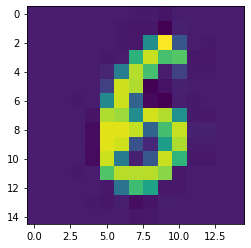

In [11]:
plt.imshow(x_train_small[5].reshape((x_train_small.shape[1],x_train_small.shape[2])))

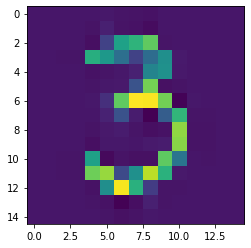

In [12]:
plt.imshow(x_train_3_small[7].reshape((x_train_3_small.shape[1],x_train_3_small.shape[2])))

In [13]:
x_train_small = x_train_small.reshape(x_train_small.shape[0],INPUT_DATA_SIZE,INPUT_DATA_SIZE)
x_test_small = x_test_small.reshape(x_test_small.shape[0],INPUT_DATA_SIZE,INPUT_DATA_SIZE)

x_train_3_small = x_train_3_small.reshape(x_train_3_small.shape[0],INPUT_DATA_SIZE,INPUT_DATA_SIZE)
x_test_3_small = x_train_3_small.reshape(x_train_3_small.shape[0],INPUT_DATA_SIZE,INPUT_DATA_SIZE)

## training

In [14]:
def cost_batch(params, batch):
    loss = 0.0
    for i in batch:
        f = circuit(params, i)
        loss = loss + (1 - f) ** 2
    return loss / len(batch)

def cost(params):
    loss = 0.0
    for i in range(len(x_train)):
        f = circuit(params, x_train[i])
        loss = loss + (1 - f) ** 2
    return loss / len(x_train)

def cost_sample(params, single_sample):
    return (1 - circuit(params, single_sample)) ** 2

In [15]:
def iterate_minibatches(data, batch_size):
    for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield data[idxs]

In [16]:
learning_rate = 0.01
epochs = 2
batch_size = 20 

In [17]:
opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
#opt = qml.QNGOptimizer(learning_rate)
# opt = GradientDescentOptimizer(learning_rate)

In [18]:
weight_shapes = {"weights": (DRCs*num_upload_params)}
params = np.random.uniform(size=weight_shapes["weights"], requires_grad=True)

In [19]:
params.shape

(450,)

In [20]:
x_train_small = x_train_small[:2000]
x_test_small = x_test_small[:2000]
x_train_3_small = x_train_3_small[:2000]
x_test_3_small = x_test_3_small[:2000]

In [21]:
start = time.time()

for it in range(epochs):
    start_b = time.time()
    for j,Xbatch in enumerate(iterate_minibatches(x_train_small, batch_size=batch_size)):  
    #for j, sample in enumerate(x_train_small):        
        #sample = np.array(sample, requires_grad=False)
        #cost_fn = lambda p: cost_sample(p, sample)
        cost_fn = lambda p: cost_batch(p, Xbatch)
        #metric_fn = lambda p: qml.metric_tensor(circuit, approx="block-diag")(p, sample)
        params = opt.step(cost_fn, params)#, metric_tensor_fn=metric_fn)
        print(j, end="\r")
        if j % 20 == 0:
            end_b = time.time()
            loss = cost_batch(params,Xbatch)
            print(f"Step: {j} | Loss: {loss:.3} | avg step time {(end_b - start_b) / 100 :.3}")
            start_b = time.time()

    loss = cost_batch(params,x_train_small)
    val_loss = cost_batch(params, x_test_small)
    print("____")
    print(f"Epoch: {it} | Loss: {loss:.3} | Val Loss {val_loss:.3}")
    print("____")
    
end = time.time()

print(f"Time for {epochs} epochs: {end - start}")

Step: 0 | Loss: 0.969 | avg step time 6.91
Step: 20 | Loss: 0.107 | avg step time 1.38e+02
Step: 40 | Loss: 0.0473 | avg step time 1.45e+02



KeyboardInterrupt



In [ ]:
pred_six = np.array([circuit(params,i) for i in x_test_small])
np.mean(pred_six)
print("Median six reconstruciton fidelities: ",np.median(pred_six))

pred_three = np.array([circuit(params,i) for i in x_test_3_small])
np.mean(pred_three)
print("Median three reconstruciton fidelities: ",np.median(pred_three))

In [ ]:
bins = np.histogram(np.hstack((pred_six.reshape((pred_six.shape[0],)), pred_three.reshape((pred_three.shape[0],)))), bins=50)[1]
plt.hist(pred_six, histtype='step', label="sixes",bins=bins)
plt.hist(pred_three, histtype='step', label="threes",bins=bins)

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

bce_background = 1-pred_six
bce_signal = 1-pred_three

y_true = np.append(np.zeros(len(bce_background)), np.ones(len(bce_signal)))
y_pred = np.append(bce_background, bce_signal)
auc = roc_auc_score(y_true, y_pred)

print("AUC: ", auc)

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
tnr = 1 - fpr
x = np.linspace(0,1,50)
y_rnd = 1 - x
plt.plot(tnr,tpr, label="anomaly tagging")
plt.plot(x,y_rnd, label="random tagging", color='grey')
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()

In [ ]:
def acc_for_threshold(T):
    # sixes that are predicted six
    num_six_right = np.sum(pred_six > T)
    # threes that are predicted three
    num_three_right = np.sum(pred_three < T)
    acc = (num_six_right + num_three_right)/(len(pred_six) + len(pred_three))
    return acc

Ts = np.linspace(0.9,1,9000)
accs = []
for i in Ts:
    accs.append(acc_for_threshold(i))
print(max(accs))
plt.ylabel("Tagging accuracy")
plt.xlabel("Anomaly threshold")
plt.plot(Ts, accs)  